In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.utils import class_weight
from keras_preprocessing import image as im
tf.random.set_seed(
    5
)

# Loading data

In [3]:
def load_data(image_path, annotations_path):
    df = pd.read_csv(annotations_path)
    df = df[~df['human_sentiment'].isna()]
    in_folder = os.listdir(image_path)
    df.loc[df['image_name'].isin(in_folder), 'image_name'] = \
    df.loc[df['image_name'].isin(in_folder), 'image_name'].apply(lambda x: os.path.join(image_path,x))
    images = []
    for image_name in df['image_name'].values:
        images.append(np.array(im.load_img(image_name, target_size=(224,224))))
    images = np.array(images)
    images = images/255
    annotations = df['annotation'].str.lower().values
    return images, annotations

In [4]:
images, annotations = load_data("../../../../images/", '../../../../emo-at-cap.csv')

# Processing of data

In [5]:
import nltk

In [6]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [7]:
tokenized = [tokenizer.tokenize(i) for i in annotations]

In [8]:
unique_tokens, unique_counts = np.unique(np.hstack(tokenized), return_counts=True)

In [9]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(np.hstack(tokenized)), np.hstack(tokenized))

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=["'" ',' '-' ... 'youth' 'исходный' 'текст'], y=['the' 'man' 'is' ... 'with' 'some' 'clothes'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [10]:
frequency = sorted(list(zip(unique_tokens, unique_counts)), key = lambda x: x[1])[::-1][:50]

In [11]:
frequency

[('the', 3261),
 ('is', 2031),
 ('man', 1905),
 ('and', 1536),
 ('woman', 1361),
 ('are', 1036),
 ('a', 963),
 ('to', 891),
 ('looks', 751),
 ('happy', 705),
 ('with', 547),
 ('something', 480),
 ('men', 478),
 ('of', 463),
 ('two', 408),
 ('other', 361),
 ('people', 343),
 ('couple', 334),
 (',', 330),
 ('in', 278),
 ('look', 270),
 ('because', 265),
 ('they', 256),
 ('about', 247),
 ('on', 246),
 ('at', 192),
 ('trying', 190),
 ('serious', 189),
 ('women', 184),
 ('each', 179),
 ('together', 176),
 ('by', 175),
 ('having', 171),
 ('flirting', 165),
 ('he', 155),
 ('smiling', 151),
 ('arguing', 141),
 ('angry', 140),
 ('scared', 138),
 ('worried', 137),
 ('hugging', 135),
 ('surprised', 134),
 ('calm', 133),
 ('company', 131),
 ('her', 129),
 ('group', 123),
 ('for', 121),
 ('she', 117),
 ('looking', 117),
 ('his', 115)]

In [12]:
len(unique_tokens)

2162

In [13]:
pad_token = '<PAD>'
start_token = '<S>'
end_token = '<E>'

In [14]:
vocab = dict(zip(unique_tokens,list(range(3,len(unique_tokens)+3))))
vocab[pad_token] = 0
vocab[start_token] = 1
vocab[end_token] = 2

In [15]:
inverse_vocab = dict([(v,k) for k,v in vocab.items()])

In [16]:
def padd(sentences, pad_token, start_token, end_token, maxlen=10):
    padded_sentences = []
    for i in sentences:
        sentence = [start_token] + i + [end_token]
        if len(sentence)>=maxlen+2:
            sentence = sentence[:maxlen+2]
        else:
            sentence = sentence+[pad_token for i in range(maxlen+2-len(sentence))]
        padded_sentences.append(sentence)
    return padded_sentences

In [17]:
padded_sentences = padd(tokenized, pad_token, start_token, end_token, maxlen=10)

In [18]:
np.mean([len(i) for i in padded_sentences])

12.0

In [19]:
indexed = list(map(lambda x: [vocab[i] for i in x],padded_sentences))

In [20]:
images.shape

(3840, 224, 224, 3)

In [21]:
len(class_weights)

2162

In [22]:
class_weights = list(class_weights)
class_weights.insert(0, 1)
class_weights.insert(1, 1)
class_weights.insert(2, 1)

In [23]:
len(class_weights), len(vocab)

(2165, 2165)

In [24]:
class_weights[:4]

[1, 1, 1, 0.21013259327782918]

In [25]:
class_weights = np.array(class_weights)

In [26]:
class_weights.shape

(2165,)

# Model with transfer learning

In [27]:
def calc_size(x, f, s, padding='same'):
    p = 2 if padding=='same' else 1
    return (x-f+2)/s+1

### Convolutional model

In [28]:
import tensorflow.keras.applications as apps


In [29]:
class ConvEncoder(tf.keras.Model):
    def __init__(self):
        super(ConvEncoder, self).__init__()
        #building resnet
        self.resnet_extractor = apps.ResNet152V2(include_top=False, weights='imagenet')
        self.resnet_extractor.trainable = False
        self.pooling = tf.keras.layers.GlobalAveragePooling2D()
        self.dense1 = tf.keras.layers.Dense(units=256, activation='relu')

    def call(self, input):
        extracted = self.pooling(self.resnet_extractor(input))
        return self.dense1(extracted)

In [30]:
conv_encoder = ConvEncoder()

In [31]:
conv_res = conv_encoder(np.expand_dims(images[0],axis=0))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [32]:
conv_res

<tf.Tensor: shape=(1, 256), dtype=float32, numpy=
array([[0.        , 0.45110336, 0.        , 0.89991987, 0.04021144,
        1.0338808 , 0.        , 1.2185136 , 0.        , 0.782475  ,
        0.17089272, 0.        , 0.3954255 , 0.1671195 , 0.15840793,
        1.2803926 , 0.        , 0.        , 1.124241  , 0.6615209 ,
        0.17552686, 0.5491359 , 0.3783183 , 0.91132826, 0.        ,
        0.        , 0.91129327, 0.        , 0.        , 0.48045927,
        0.9253241 , 0.3848397 , 0.5545056 , 0.        , 0.        ,
        0.64365286, 0.46524224, 0.        , 0.88236815, 0.10199666,
        0.14806433, 0.55172324, 0.        , 0.58297265, 0.        ,
        0.        , 1.2747003 , 0.        , 1.9214393 , 0.7078986 ,
        0.        , 0.8450792 , 0.765275  , 0.        , 0.        ,
        0.5421102 , 0.57547665, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.1631012 , 0.        , 1.610235  ,
        0.        , 0.        , 2.0704203 , 0.8703097 , 0.        

### LSTM model

### making w2v embeddings

In [33]:
!pip install gensim

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [34]:
import gensim.downloader as api

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [35]:
w2v_embeddings = api.load('word2vec-google-news-300')

In [36]:
def build_embeddings(vocab, word_vectors, embed_dim):
    emb_matrix = np.zeros(shape=(len(vocab)+ 1 , embed_dim), dtype='float32')
    count = 0
    for word, i in vocab.items():
        try:
            emb_matrix[i, :] = word_vectors.get_vector(word)
        except:
            count += 1
            emb_matrix[i, :] = np.random.uniform(-0.1, 0.1, embed_dim)
    print('{} words are out of vocabulary：'.format(count))
    return emb_matrix


In [37]:
w2v_embeddings = build_embeddings(vocab, w2v_embeddings, 300)

22 words are out of vocabulary：


### attention

In [38]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

### building model

In [39]:
class LSTMDecoder(tf.keras.Model):
    def __init__(self, max_tokens, units=512, embeddings=None, dim=128):
        super(LSTMDecoder, self).__init__()
        self.units = units
        self.embeddings = tf.keras.layers.Embedding(input_dim=max_tokens+1, output_dim=dim, name='embeddings',
                                                   weights=[embeddings])
        self.dropout = tf.keras.layers.SpatialDropout1D(0.2)
        self.lstm = tf.keras.layers.LSTM(units=self.units, return_state=True, return_sequences=True, name='lstm_decoder', 
                                         recurrent_dropout=0.1,recurrent_initializer='glorot_uniform')
        self.intermidiate_dense = tf.keras.layers.Dense(units=self.units, activation='relu')
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6, name='layer_normalization')
        self.output_dense = tf.keras.layers.Dense(units=max_tokens)
        self.attention = BahdanauAttention(self.units)

    def call(self, input, features, hidden):
        embedded = self.dropout(self.embeddings(input))
        context_vector, attention_weights = self.attention(features, hidden)
        concated = tf.concat([tf.expand_dims(context_vector, 1), embedded], axis=-1)
        result_lstm, state_h, state_c = self.lstm(concated)
        intermidiate_dense = self.intermidiate_dense(self.layer_norm (result_lstm))
        intermidiate_dense = tf.reshape(intermidiate_dense, (-1, intermidiate_dense.shape[2]))
        logits = self.output_dense(intermidiate_dense)
        return logits, state_h, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [40]:
lstm_decoder = LSTMDecoder(len(inverse_vocab), 256, w2v_embeddings, dim=300)

### Training

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',
                                                                         from_logits=True)
lr_value = 1e-4
reduction_power = 10
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_value)
with_weights = False

In [43]:
epochs = 30
batch_size = 64
patience_epochs = 2

In [44]:
def loss_function(real, pred, loss_weights):
        mask = tf.math.logical_not(tf.math.equal(real, vocab[pad_token]))
        loss_ = loss_object(real, pred)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        loss_weights = tf.cast(loss_weights, dtype=loss_.dtype)
        loss_*=loss_weights
        return loss_

In [45]:
@tf.function
def train_step(image, target, lengths, optimizer):
    hidden = lstm_decoder.reset_state(batch_size=target.shape[0])

    with tf.GradientTape() as tape:
        features = conv_encoder(image)
        # Teacher forcing - feeding the target as the next input
        batched_loss = []
        for t in range(1, target.shape[1]):
            
            dec_input = tf.expand_dims(target[:, t-1], 1)
            result, hidden, _ = lstm_decoder(dec_input, features, hidden)
            weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
            weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
            batched_loss.append(loss_function(target[:, t], result, weights))
        batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
        batched_loss = tf.reduce_sum(batched_loss, axis=1)
        lengths = tf.cast(lengths, dtype=batched_loss.dtype)
        loss = tf.reduce_mean(batched_loss / lengths)

    perplexity = tf.exp(loss)

    variables = conv_encoder.trainable_variables + lstm_decoder.trainable_variables
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return loss, perplexity

In [46]:
@tf.function
def evaluate(image, target, lengths, optimizer):
    hidden = lstm_decoder.reset_state(batch_size=target.shape[0])

    features = conv_encoder(image)
    # Teacher forcing - feeding the target as the next input
    batched_loss = []
    for t in range(1, target.shape[1]):

        dec_input = tf.expand_dims(target[:, t-1], 1)
        result, hidden, _ = lstm_decoder(dec_input, features, hidden)
        weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
        weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
        batched_loss.append(loss_function(target[:, t], result, weights))
    
    batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
    batched_loss = tf.reduce_sum(batched_loss, axis=1)
    lengths = tf.cast(lengths, dtype=batched_loss.dtype)
    loss = tf.reduce_mean(batched_loss / lengths)
    perplexity = tf.exp(loss)


    return loss, perplexity

In [47]:
train_images, val_images, train_sequences, val_sequences =  train_test_split(images, indexed, test_size=0.2, random_state=10)
val_images, test_images, val_sequences, test_sequences =  train_test_split(val_images, val_sequences, test_size=0.5, random_state=10)

In [48]:
train_length = (np.array(train_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [49]:
val_length = (np.array(val_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [50]:
test_length = (np.array(test_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [51]:
train_images = np.array(np.array_split(train_images, len(train_images)//batch_size))
test_images = np.array(np.array_split(test_images, len(test_images)//batch_size))
val_images = np.array(np.array_split(val_images, len(val_images)//batch_size))

train_sequences = np.array(np.array_split(train_sequences, len(train_sequences)//batch_size))
test_sequences = np.array(np.array_split(test_sequences, len(test_sequences)//batch_size))
val_sequences = np.array(np.array_split(val_sequences, len(val_sequences)//batch_size))

train_length = np.array(np.array_split(train_length, len(train_length)//batch_size))
test_length = np.array(np.array_split(test_length, len(test_length)//batch_size))
val_length = np.array(np.array_split(val_length, len(val_length)//batch_size))


In [52]:
train_images.shape, train_sequences.shape, train_length.shape

((48, 64, 224, 224, 3), (48, 64, 12), (48, 64))

In [53]:
!pip install tqdm

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [54]:
if not with_weights:
    class_weights = np.array([1 for i in range(len(class_weights))])

In [55]:
from tqdm import tqdm

In [56]:
train_loss = []
train_perplexity = []
val_loss = []
val_perplexity = []
overfit_epochs = 0
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_perplexity = 0
    epoch_val_loss = 0
    epoch_val_perplexity = 0
    for batch_train_images, batch_train_sequences, batched_train_length in tqdm(zip(train_images,train_sequences,train_length)):
        batched_train_loss, batched_train_perplexity = train_step(batch_train_images,batch_train_sequences,batched_train_length, optimizer)
        epoch_train_loss+=batched_train_loss
        epoch_train_perplexity+=batched_train_perplexity
    epoch_train_loss = epoch_train_loss/train_images.shape[0]
    epoch_train_perplexity = epoch_train_perplexity/train_images.shape[0]
    train_loss.append(epoch_train_loss)
    train_perplexity.append(epoch_train_perplexity)
    print('Finished epoch {}; Train loss : {}; Train perplexity : {}'.format(epoch,epoch_train_loss,epoch_train_perplexity))
    for batch_val_images, batch_val_sequences, batched_val_length in zip(val_images,val_sequences,val_length):
        batched_val_loss, batched_val_perplexity = evaluate(batch_val_images, batch_val_sequences, batched_val_length, optimizer)
        epoch_val_loss+=batched_val_loss
        epoch_val_perplexity+=batched_val_perplexity
    epoch_val_loss = epoch_val_loss/val_images.shape[0]
    epoch_val_perplexity = epoch_val_perplexity/val_images.shape[0]
    val_perplexity.append(epoch_val_perplexity)
    val_loss.append(epoch_val_loss)
    print('Validation loss : {}; Validation perplexity : {}'.format(epoch_val_loss,epoch_val_perplexity))
    if len(val_loss)>=2 and val_loss[-2]<val_loss[-1]:
        overfit_epochs+=1
    else:
        overfit_epochs=0
    if overfit_epochs==patience_epochs:
        lr_value/=reduction_power
        optimizer.lr.assign(lr_value)
        print('There was no improvement in validation loss for {} epochs, thus reducing learning rate'.format(patience_epochs))

48it [01:22,  1.71s/it]


Finished epoch 0; Train loss : 6.8639678955078125; Train perplexity : 1484.48828125
Validation loss : 5.742802143096924; Validation perplexity : 316.0199890136719


48it [00:51,  1.06s/it]


Finished epoch 1; Train loss : 5.267052173614502; Train perplexity : 199.71893310546875
Validation loss : 5.01556921005249; Validation perplexity : 152.7976531982422


48it [00:51,  1.07s/it]


Finished epoch 2; Train loss : 4.6842498779296875; Train perplexity : 110.16101837158203
Validation loss : 4.633707523345947; Validation perplexity : 104.33972930908203


48it [00:51,  1.07s/it]


Finished epoch 3; Train loss : 4.330959320068359; Train perplexity : 77.24191284179688
Validation loss : 4.375945568084717; Validation perplexity : 80.7385025024414


48it [00:51,  1.07s/it]


Finished epoch 4; Train loss : 4.098356246948242; Train perplexity : 61.11910629272461
Validation loss : 4.229159832000732; Validation perplexity : 69.86200714111328


48it [00:51,  1.07s/it]


Finished epoch 5; Train loss : 3.925828695297241; Train perplexity : 51.42470932006836
Validation loss : 4.133240222930908; Validation perplexity : 63.590328216552734


48it [00:51,  1.07s/it]


Finished epoch 6; Train loss : 3.8024823665618896; Train perplexity : 45.40707778930664
Validation loss : 4.074037075042725; Validation perplexity : 60.06574630737305


48it [00:51,  1.08s/it]


Finished epoch 7; Train loss : 3.704434633255005; Train perplexity : 41.15073776245117
Validation loss : 4.051372528076172; Validation perplexity : 58.83658981323242


48it [00:51,  1.07s/it]


Finished epoch 8; Train loss : 3.623656988143921; Train perplexity : 37.91963577270508
Validation loss : 4.004963397979736; Validation perplexity : 56.22182083129883


48it [00:51,  1.07s/it]


Finished epoch 9; Train loss : 3.5566813945770264; Train perplexity : 35.45401382446289
Validation loss : 3.9888200759887695; Validation perplexity : 55.3848762512207


48it [00:51,  1.07s/it]


Finished epoch 10; Train loss : 3.49922251701355; Train perplexity : 33.454322814941406
Validation loss : 3.970899820327759; Validation perplexity : 54.42628479003906


48it [00:51,  1.08s/it]


Finished epoch 11; Train loss : 3.448575735092163; Train perplexity : 31.789369583129883
Validation loss : 3.984693765640259; Validation perplexity : 55.345584869384766


48it [00:51,  1.07s/it]


Finished epoch 12; Train loss : 3.405001640319824; Train perplexity : 30.420442581176758
Validation loss : 3.9614479541778564; Validation perplexity : 54.001522064208984


48it [00:51,  1.07s/it]


Finished epoch 13; Train loss : 3.364314317703247; Train perplexity : 29.199052810668945
Validation loss : 3.970543146133423; Validation perplexity : 54.676910400390625


48it [00:51,  1.07s/it]


Finished epoch 14; Train loss : 3.3284413814544678; Train perplexity : 28.163238525390625
Validation loss : 3.9840126037597656; Validation perplexity : 55.46457290649414
There was no improvement in validation loss for 2 epochs, thus reducing learning rate


48it [00:51,  1.07s/it]


Finished epoch 15; Train loss : 3.2906980514526367; Train perplexity : 27.110227584838867
Validation loss : 3.9530398845672607; Validation perplexity : 53.76313400268555


48it [00:51,  1.07s/it]


Finished epoch 16; Train loss : 3.282825231552124; Train perplexity : 26.89593505859375
Validation loss : 3.9516563415527344; Validation perplexity : 53.67934036254883


48it [00:51,  1.07s/it]


Finished epoch 17; Train loss : 3.278172492980957; Train perplexity : 26.76995277404785
Validation loss : 3.9514639377593994; Validation perplexity : 53.6666145324707


48it [00:51,  1.07s/it]


Finished epoch 18; Train loss : 3.2739524841308594; Train perplexity : 26.65620231628418
Validation loss : 3.9516775608062744; Validation perplexity : 53.679012298583984


48it [00:51,  1.07s/it]


Finished epoch 19; Train loss : 3.269918203353882; Train perplexity : 26.547807693481445
Validation loss : 3.9518558979034424; Validation perplexity : 53.6898078918457
There was no improvement in validation loss for 2 epochs, thus reducing learning rate


48it [00:51,  1.07s/it]


Finished epoch 20; Train loss : 3.265401840209961; Train perplexity : 26.427352905273438
Validation loss : 3.9516193866729736; Validation perplexity : 53.67073440551758


48it [00:51,  1.07s/it]


Finished epoch 21; Train loss : 3.264810562133789; Train perplexity : 26.411582946777344
Validation loss : 3.951493501663208; Validation perplexity : 53.66097640991211


48it [00:51,  1.07s/it]


Finished epoch 22; Train loss : 3.2643251419067383; Train perplexity : 26.398651123046875
Validation loss : 3.9514129161834717; Validation perplexity : 53.655391693115234


48it [00:51,  1.07s/it]


Finished epoch 23; Train loss : 3.2638843059539795; Train perplexity : 26.386911392211914
Validation loss : 3.951369047164917; Validation perplexity : 53.65249252319336


48it [00:51,  1.07s/it]


Finished epoch 24; Train loss : 3.2634639739990234; Train perplexity : 26.375722885131836
Validation loss : 3.951306104660034; Validation perplexity : 53.64892578125


48it [00:51,  1.07s/it]


Finished epoch 25; Train loss : 3.2630531787872314; Train perplexity : 26.364816665649414
Validation loss : 3.9512712955474854; Validation perplexity : 53.64692306518555


48it [00:51,  1.07s/it]


Finished epoch 26; Train loss : 3.26265025138855; Train perplexity : 26.35411262512207
Validation loss : 3.9512622356414795; Validation perplexity : 53.64633560180664


48it [00:51,  1.07s/it]


Finished epoch 27; Train loss : 3.262251853942871; Train perplexity : 26.34352684020996
Validation loss : 3.9512481689453125; Validation perplexity : 53.64559555053711


48it [00:51,  1.07s/it]


Finished epoch 28; Train loss : 3.261855125427246; Train perplexity : 26.33299446105957
Validation loss : 3.951235771179199; Validation perplexity : 53.64493942260742


48it [00:51,  1.07s/it]


Finished epoch 29; Train loss : 3.2614612579345703; Train perplexity : 26.322538375854492
Validation loss : 3.951226234436035; Validation perplexity : 53.64448165893555


# Viewing and saving results

In [57]:
df = pd.DataFrame()
model_name = 'conv_lstm_logits_transfer_learning_w2v_fixed_size_attention'
df['train_perplexity'] = [i.numpy() for i in train_perplexity]
df['val_perplexity'] = [i.numpy() for i in val_perplexity]
df['train_loss'] = [i.numpy() for i in train_loss]
df['val_loss'] = [i.numpy() for i in val_loss]


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

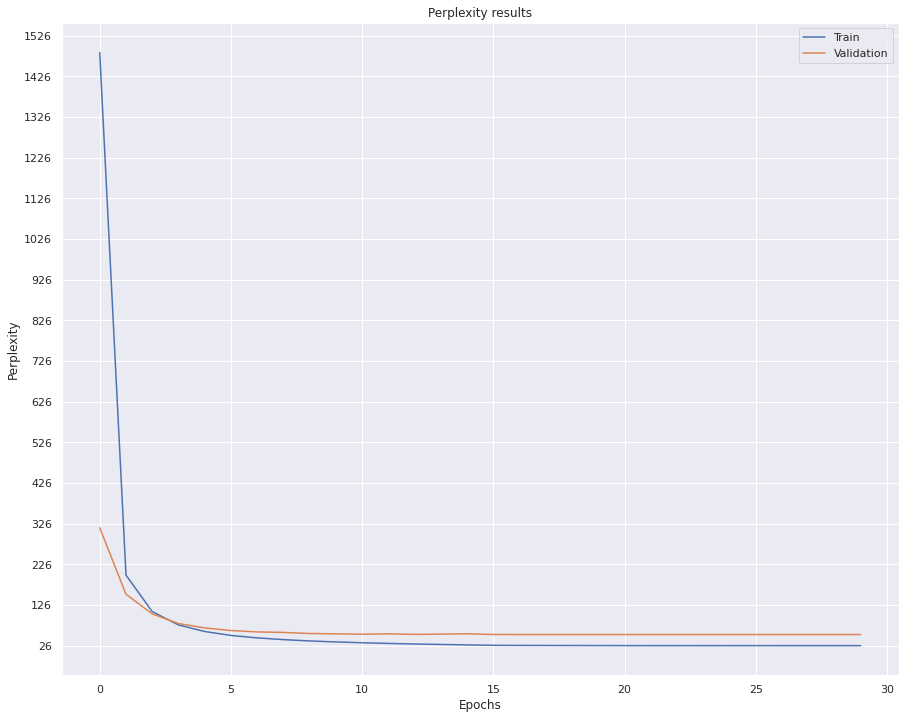

In [59]:
plt.figure(figsize=(15,12))
plt.title('Perplexity results')
plt.plot(df['train_perplexity'])
plt.plot(df['val_perplexity'])
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.yticks(np.arange(min(df['train_perplexity']), max(df['train_perplexity'])+100,100))
plt.legend(['Train', 'Validation']);

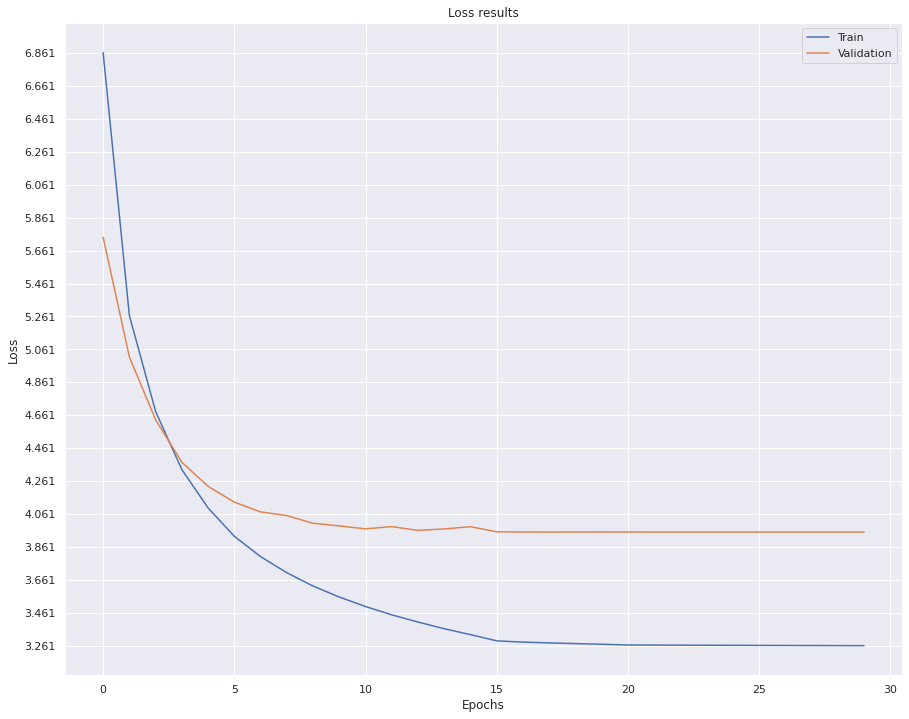

In [60]:
plt.figure(figsize=(15,12))
plt.title('Loss results')
plt.plot(df['train_loss'])
plt.plot(df['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(min(df['train_loss']),max(df['train_loss']),0.2))
plt.legend(['Train', 'Validation']);

# Testing model

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
class Decoder:
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = None,
                 units:int = 256):
        self.encoder = encoder
        self.decoder = decoder
        self.max_len = max_len if max_len else 100
        self.start_token = start_token
        self.end_token = end_token
        self.units = units

    def decode(self, input):
        pass


class GreedyDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 units:int = 256
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len,
                         units
                         )

    def decode(self, input):
        features = self.encoder(np.expand_dims(input, axis=0))
        hidden = np.zeros((1,self.units))
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = self.start_token
        res = []
        while True:
            # Sample a token
            output, hidden, _ = self.decoder(target_seq,features,hidden)
            sampled_token_index = np.argmax(tf.nn.softmax(output.numpy()))
            if len(res) > self.max_len or sampled_token_index == self.end_token:
                break

            res.append(sampled_token_index)

            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

       
        return res


In [63]:
class BeamSearchDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 units:int = 256
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len,
                         units
                         )

    def decode(self, input, beam_size=3):
        start = [self.start_token]
        features = self.encoder(np.expand_dims(input,axis=0))

        hidden = np.zeros((1,self.units))
        start_word = [[start, 0.0, hidden]]

        while len(start_word[0][0]) < self.max_len:
            temp = []
            for s in start_word:
                target_seq = np.array([[s[0][-1]]])
                hidden = s[-1]
                output, hidden, _ = self.decoder(target_seq, features, hidden)
                output = np.hstack(output)
                output = tf.nn.softmax(output).numpy()
                word_preds = np.argsort(output)[-beam_size:]

                for w in word_preds:
                    next_cap, prob = s[0][:], s[1]
                    next_cap.append(w)
                    prob += output[w]
                    temp.append([next_cap, prob, hidden])

            start_word = temp
            # Sorting according to the probabilities
            start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
            # Getting the top words
            start_word = start_word[-beam_size:]

        start_word = start_word[-1][0]

        final_caption = []

        for i in start_word:
            if i != self.end_token:
                final_caption.append(i)
            else:
                break
        return final_caption[1:]

In [64]:
def predict(data, decoder, inverse_vocab,
           beam_size=None):
    if beam_size:
        result = decoder.decode(data, beam_size=beam_size)
    else:
        result = decoder.decode(data)
    return ' '.join([inverse_vocab[i] for i in result])

In [65]:
greedy_decoder = GreedyDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=10, units=256)

In [66]:
beam_decoder = BeamSearchDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=10, units=256)

In [67]:
images.shape

(3840, 224, 224, 3)

In [68]:
idx = np.random.choice(range(len(images)))
sample = images[idx]

the man is flirting with the woman


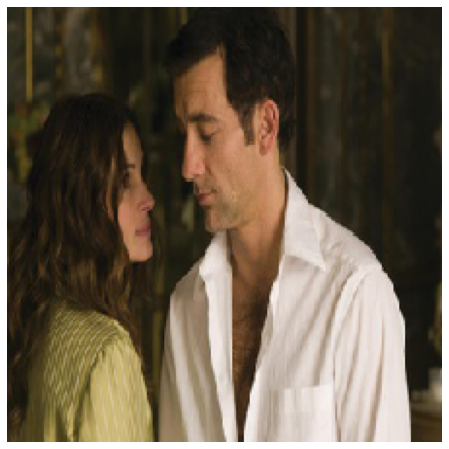

In [69]:
plt.figure(figsize=(8,8))
plt.imshow(sample)
plt.grid([])
plt.axis('off');
print(annotations[idx])

In [70]:
predict(sample, greedy_decoder, inverse_vocab)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



'the man'

In [71]:
predict(sample, beam_decoder, inverse_vocab, beam_size=3)

'man is looking at something'

In [72]:
predict(sample, beam_decoder, inverse_vocab, beam_size=5)

'woman'

In [73]:
predict(sample, beam_decoder, inverse_vocab, beam_size=7)

'woman'

In [74]:
predict(sample, beam_decoder, inverse_vocab, beam_size=10)

'conversation'

# Blue score calculation

In [75]:
from nltk.translate.bleu_score import sentence_bleu


### making predictions on test dataset with beam_size of 5

In [76]:
test_predictions = []
for batch in tqdm(test_images):
    for image in batch:
        result = predict(image, beam_decoder, inverse_vocab, beam_size=5)
        test_predictions.append(result)

100%|██████████| 6/6 [05:36<00:00, 56.16s/it]


In [77]:
test_predictions = [i.split(' ') for i in test_predictions]

In [78]:
reshaped_sequences = test_sequences.reshape(test_sequences.shape[0]*test_sequences.shape[1],-1)

In [79]:
test_sentences = []
for i in reshaped_sequences:
    tmp = []
    for word in i:
        if word!=0 and word!=1 and word!=2:
            tmp.append(inverse_vocab[word])
    test_sentences.append(tmp)

In [80]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction))
print('Overall bleu score on test data : {}'.format(np.mean(bleu_score)))
df['overall_bleu'] = np.mean(bleu_score)*100

Overall bleu score on test data : 0.00723539284274746


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
ho

In [81]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(1,)))
print('Bleu score on test data for n-gram = 1 : {}'.format(np.mean(bleu_score)))
df['n1_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 1 : 0.14071945573539588


In [82]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,1)))
print('Bleu score on test data for n-gram = 2 : {}'.format(np.mean(bleu_score)))
df['n2_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 2 : 0.03947516360219264


In [83]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,1)))
print('Bleu score on test data for n-gram = 3 : {}'.format(np.mean(bleu_score)))
df['n3_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 3 : 0.010339381013435468


In [84]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,0,1)))
print('Bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['n4_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 4 : 0.004988585439539078


In [85]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0.25,0.25,0.25,0.25)))
print('Acuumulated bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['acc_bleu'] = np.mean(bleu_score)*100

Acuumulated bleu score on test data for n-gram = 4 : 0.00723539284274746


In [86]:
df.head()

,train_perplexity,val_perplexity,train_loss,val_loss,overall_bleu,n1_bleu,n2_bleu,n3_bleu,n4_bleu,acc_bleu
0,1484.488281,316.019989,6.863968,5.742802,0.723539,14.071946,3.947516,1.033938,0.498859,0.723539
1,199.718933,152.797653,5.267052,5.015569,0.723539,14.071946,3.947516,1.033938,0.498859,0.723539
2,110.161018,104.339729,4.684250,4.633708,0.723539,14.071946,3.947516,1.033938,0.498859,0.723539
3,77.241913,80.738503,4.330959,4.375946,0.723539,14.071946,3.947516,1.033938,0.498859,0.723539
4,61.119106,69.862007,4.098356,4.229160,0.723539,14.071946,3.947516,1.033938,0.498859,0.723539


In [87]:
df.to_csv('{}_logs.csv'.format(model_name),index=False)

In [88]:
conv_encoder.save_weights('{}_encoder.h5'.format(model_name))

In [89]:
lstm_decoder.save_weights('{}_decoder.h5'.format(model_name))

# Predictions on own data

In [90]:
img = np.array(im.load_img('hospital-birth.jpg', target_size=(224,224)))/255

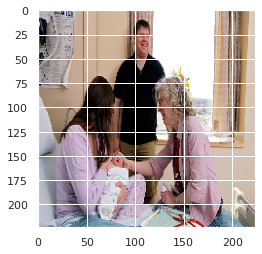

In [91]:
plt.imshow(img)

In [92]:
predict(img, greedy_decoder, inverse_vocab)

'the man is hugging'

In [93]:
predict(img, beam_decoder, inverse_vocab, beam_size=3)

'the man is hugging the man is hugging'

In [94]:
predict(img, beam_decoder, inverse_vocab, beam_size=5)

'men are trying to be together'

In [95]:
predict(img, beam_decoder, inverse_vocab, beam_size=7)

'men are trying to be together'

In [96]:
predict(img, beam_decoder, inverse_vocab, beam_size=10)

'men are trying to be together'